In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import csv, warnings, math
from scipy.stats import ttest_ind
from scipy.interpolate import CubicSpline
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from adjustText import adjust_text
from poola import core as pool
import anchors

import core_functions as fns

gpp.set_aesthetics(palette='Set2')

In [2]:
import anchors
import statsmodels
from scipy import stats

def run_guide_residuals(lfc_df, paired_lfc_cols=[]):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Inputs:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    2. paired_lfc_cols: grouped list of initial populations and corresponding resistant populations 
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    if not paired_lfc_cols:
        paired_lfc_cols = fns.pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots


## Data summary
 

In [3]:
reads_plate1 = pd.read_csv('../../Data/Reads/Goujon/VeroE6/counts-JD_GPP1572_2900886_Goujon_Plate1.txt', sep ='\t')
reads_plate2 = pd.read_csv('../../Data/Reads/Goujon/VeroE6/counts-JD_GPP1571_2900886_Goujon_Plate2.txt', sep ='\t')
# pDNA reads 
reads_maxiprep = pd.read_csv('../../Data/Reads/Goujon/VeroE6/M-AD81_AACH02_XPR050_G0_CP0070_ScoresSum.csv')
data_reads = pd.merge(reads_plate1, reads_plate2, on =['Construct Barcode', 'Construct IDs'], how = 'outer')
data_reads = data_reads.drop('Construct IDs', axis =1)
reads_maxiprep = reads_maxiprep.drop('Construct IDs', axis=1)
reads = pd.merge(reads_maxiprep, data_reads, on =['Construct Barcode'], how = 'outer')
empty_cols = [col for col in reads.columns if 'EMPTY' in col]
reads = reads.copy().drop(empty_cols, axis = 1)
reads

,Construct Barcode,count,Vero E6 CRISPR population 1: CRISPR transduction efficiency 7%,"Vero E6 population 1 screen 1A (CoV-2 Resistant cells, infection 1, round 1 )","Vero E6 population 1 screen 1B (CoV-2 Resistant cells, round 2 - performed on 1A surviving cells)","Vero E6 population 1 screen 2 (CoV-2 Resistant cells, infection 2, started independently of 1A and 1B with lower cell density)",Vero E6 CRISPR population 2: CRISPR transduction efficiency 50%,"Vero E6 population 2 screen 1 (CoV-2 Resistant cells, ""infection 3"")"
0,TGATAGTAGGATAATAGCGA,67,416,176,64,713,251,735
1,AGGGTTGTAGTAGTCCGTAA,48,467,2222,2478,273,314,120
2,GCCTTCTATGAGGTCGAAGG,66,550,58,12,15,538,511
3,GATGGTGTAGAGAGTAGTGG,84,751,574,622,244,879,685
4,CCCTCAACAACCTACTATCG,68,1436,1794,1326,1227,883,544
...,...,...,...,...,...,...,...,...
84958,ATGGTACGTCGCGAACGATG,64,731,1533,2276,565,864,918
84959,CGGCGCCAATCGACGTGTCG,44,624,223,66,9,403,167
84960,GCCTCGACCGTGCGACGATA,70,963,1121,1538,781,889,865
84961,GGCTTAACGCCGCGTACAAG,37,584,236,66,109,386,480


In [4]:
# Gene Annotations
chip = pd.read_csv('../../Data/Interim/Goujon/VeroE6/CP0070_Chlorocebus_sabeus_remapped.chip', sep ='\t')
chip = chip.rename(columns={'Barcode Sequence':'Construct Barcode'})
chip_reads = pd.merge(chip[['Construct Barcode', 'Gene']], reads, on = ['Construct Barcode'], how = 'right')
chip_reads = chip_reads.rename(columns={'Gene':'Gene Symbol'})
chip_reads

,Construct Barcode,Gene Symbol,count,Vero E6 CRISPR population 1: CRISPR transduction efficiency 7%,"Vero E6 population 1 screen 1A (CoV-2 Resistant cells, infection 1, round 1 )","Vero E6 population 1 screen 1B (CoV-2 Resistant cells, round 2 - performed on 1A surviving cells)","Vero E6 population 1 screen 2 (CoV-2 Resistant cells, infection 2, started independently of 1A and 1B with lower cell density)",Vero E6 CRISPR population 2: CRISPR transduction efficiency 50%,"Vero E6 population 2 screen 1 (CoV-2 Resistant cells, ""infection 3"")"
0,TGATAGTAGGATAATAGCGA,ND1,67,416,176,64,713,251,735
1,AGGGTTGTAGTAGTCCGTAA,ND1,48,467,2222,2478,273,314,120
2,GCCTTCTATGAGGTCGAAGG,ND1,66,550,58,12,15,538,511
3,GATGGTGTAGAGAGTAGTGG,ND1,84,751,574,622,244,879,685
4,CCCTCAACAACCTACTATCG,ND2,68,1436,1794,1326,1227,883,544
...,...,...,...,...,...,...,...,...,...
88866,ATGGTACGTCGCGAACGATG,NO_SITE_144,64,731,1533,2276,565,864,918
88867,CGGCGCCAATCGACGTGTCG,NO_SITE_163,44,624,223,66,9,403,167
88868,GCCTCGACCGTGCGACGATA,NO_SITE_193,70,963,1121,1538,781,889,865
88869,GGCTTAACGCCGCGTACAAG,NO_SITE_47,37,584,236,66,109,386,480


In [5]:
#Calculate lognorm
cols = chip_reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads.dropna(), cols = cols)
lognorms = lognorms.rename(columns={'count_lognorm':'pDNA_lognorm'})

## Quality Control
### Population Distributions

In [6]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[2:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
pDNA_lfc

,Construct Barcode,Gene Symbol,Vero E6 CRISPR population 1: CRISPR transduction efficiency 7%_lfc,"Vero E6 population 1 screen 1A (CoV-2 Resistant cells, infection 1, round 1 )_lfc","Vero E6 population 1 screen 1B (CoV-2 Resistant cells, round 2 - performed on 1A surviving cells)_lfc","Vero E6 population 1 screen 2 (CoV-2 Resistant cells, infection 2, started independently of 1A and 1B with lower cell density)_lfc",Vero E6 CRISPR population 2: CRISPR transduction efficiency 50%_lfc,"Vero E6 population 2 screen 1 (CoV-2 Resistant cells, ""infection 3"")_lfc"
0,TGATAGTAGGATAATAGCGA,ND1,-0.438565,-1.409696,-2.430645,0.410298,-0.858689,0.519911
1,AGGGTTGTAGTAGTCCGTAA,ND1,0.149087,2.382273,2.526521,-0.407465,-0.139452,-1.304151
2,GCCTTCTATGAGGTCGAAGG,ND1,-0.053165,-2.485815,-3.333603,-3.246365,0.148648,0.049316
3,GATGGTGTAGAGAGTAGTGG,ND1,0.040953,-0.230167,-0.132084,-1.286650,0.493231,0.120568
4,CCCTCAACAACCTACTATCG,ND2,1.217099,1.623311,1.189902,1.138005,0.783154,0.093204
...,...,...,...,...,...,...,...,...
88866,ATGGTACGTCGCGAACGATG,NO_SITE_144,0.368664,1.483156,2.029551,0.157398,0.833759,0.885863
88867,CGGCGCCAATCGACGTGTCG,NO_SITE_163,0.644206,-0.583028,-1.855366,-2.871201,0.295016,-0.824936
88868,GCCTCGACCGTGCGACGATA,NO_SITE_193,0.625134,0.927617,1.358527,0.475977,0.753829,0.684697
88869,GGCTTAACGCCGCGTACAAG,NO_SITE_47,0.775102,-0.295555,-1.636054,-1.126242,0.458018,0.714699


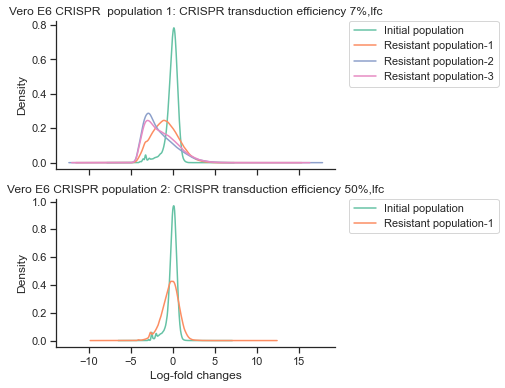

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5,6))
i,j = 0,0
cols = []
pop1_cols = [col for col in pDNA_lfc.columns if 'population 1' in col]
cols.append(pop1_cols)
pop2_cols = [col for col in pDNA_lfc.columns if 'population 2' in col]
cols.append(pop2_cols)
cols
for k,c in enumerate(cols): # k = sub-list index, c = list of columns in sub-list
    for l, c1 in enumerate(c):
        if l==0:
            label1 = 'Initial population'
        else:
            label1 = 'Resistant population-'+str(l)
        pDNA_lfc[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax[i], legend=True)
        ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    t = ax[i].set_xlabel('Log-fold changes')
    title = ','.join(c[0].split('_')[:2])
    t = ax[i].set_title(title)
    i+=1
    
fig.savefig('../../Figures/Goujon_Vero_population_distributions.png', bbox_inches="tight")

### Distributions of control sets 

In [8]:
# NO_SITE controls -> default controls 
controls = fns.get_controls(pDNA_lfc, control_name=['NO_SITE'])

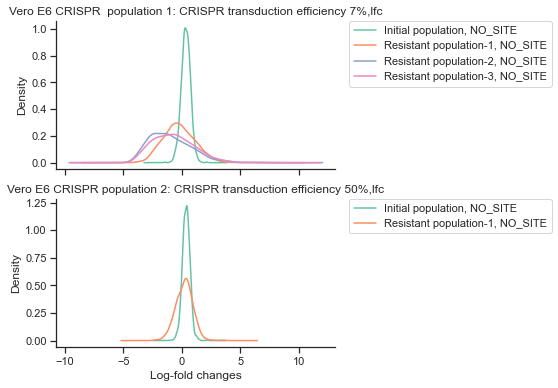

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5,6))
i,j = 0,0

for k,c in enumerate(cols): # k = sub-list index, c = list of columns in sub-list
    for l, c1 in enumerate(c):
        if l==0:
            label1 = 'Initial population, NO_SITE'
        else:
            label1 = 'Resistant population-'+str(l) + ', NO_SITE'
        controls[c1].plot(kind='kde',color=sns.color_palette('Set2')[l],label=label1, ax=ax[i], legend=True)
        ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    t = ax[i].set_xlabel('Log-fold changes')
    title = ','.join(c[0].split('_')[:2])
    t = ax[i].set_title(title)
    i+=1

fig.savefig('../../Figures/Goujon_Vero_control_distributions.png', bbox_inches="tight")

## ROC-AUC

Text(0, 0.5, 'True Positive Rate (essential)')

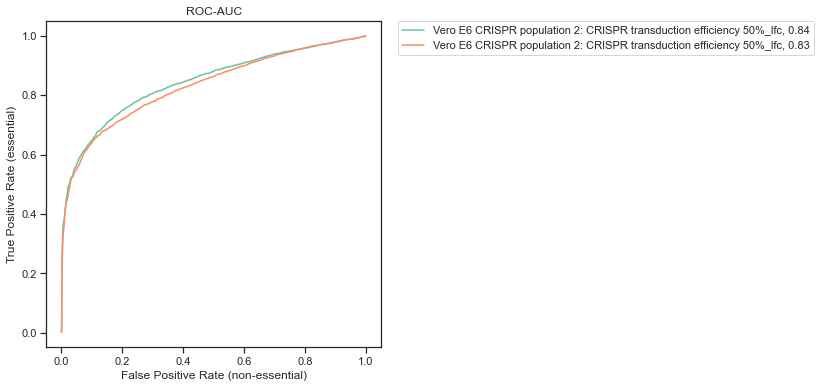

In [10]:
ess_genes, non_ess_genes = fns.get_gene_sets()

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_cols = [pop1_cols[0], pop2_cols[0]]
initial_roc_df_dict = {}
initial_roc_auc_dict = {}

for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_df_dict[col] =roc_df
    initial_roc_auc_dict[col]=roc_auc

    
fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_df_dict.items():
    roc_auc = initial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = col+', ' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene level analysis

### Residual z-scores

In [11]:
# pDNA_lfc.drop_duplicates().to_csv('../../Data/Interim/Goujon/VeroE6/Goujon_Vero_lfc.txt', sep = '\t', index = False)
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,Vero E6 CRISPR population 1: CRISPR transduction efficiency 7%_lfc,"Vero E6 population 1 screen 1A (CoV-2 Resistant cells, infection 1, round 1 )_lfc","Vero E6 population 1 screen 1B (CoV-2 Resistant cells, round 2 - performed on 1A surviving cells)_lfc","Vero E6 population 1 screen 2 (CoV-2 Resistant cells, infection 2, started independently of 1A and 1B with lower cell density)_lfc",Vero E6 CRISPR population 2: CRISPR transduction efficiency 50%_lfc,"Vero E6 population 2 screen 1 (CoV-2 Resistant cells, ""infection 3"")_lfc"
0,TGATAGTAGGATAATAGCGA,-0.438565,-1.409696,-2.430645,0.410298,-0.858689,0.519911
1,AGGGTTGTAGTAGTCCGTAA,0.149087,2.382273,2.526521,-0.407465,-0.139452,-1.304151
2,GCCTTCTATGAGGTCGAAGG,-0.053165,-2.485815,-3.333603,-3.246365,0.148648,0.049316
3,GATGGTGTAGAGAGTAGTGG,0.040953,-0.230167,-0.132084,-1.286650,0.493231,0.120568
4,CCCTCAACAACCTACTATCG,1.217099,1.623311,1.189902,1.138005,0.783154,0.093204
...,...,...,...,...,...,...,...
88866,ATGGTACGTCGCGAACGATG,0.368664,1.483156,2.029551,0.157398,0.833759,0.885863
88867,CGGCGCCAATCGACGTGTCG,0.644206,-0.583028,-1.855366,-2.871201,0.295016,-0.824936
88868,GCCTCGACCGTGCGACGATA,0.625134,0.927617,1.358527,0.475977,0.753829,0.684697
88869,GGCTTAACGCCGCGTACAAG,0.775102,-0.295555,-1.636054,-1.126242,0.458018,0.714699


In [12]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, cols)
residuals_lfcs


                                            modified  \
0  Vero E6 population 1 screen 1A (CoV-2 Resistan...   
1  Vero E6 population 1 screen 1B (CoV-2 Resistan...   
2  Vero E6 population 1 screen 2  (CoV-2 Resistan...   
3  Vero E6 population 2 screen 1 (CoV-2 Resistant...   

                                         unperturbed  
0  Vero E6 CRISPR  population 1: CRISPR transduct...  
1  Vero E6 CRISPR  population 1: CRISPR transduct...  
2  Vero E6 CRISPR  population 1: CRISPR transduct...  
3  Vero E6 CRISPR population 2: CRISPR transducti...  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,TGATAGTAGGATAATAGCGA,Vero E6 population 1 screen 1A (CoV-2 Resistan...,-0.083839,-0.061870,Vero E6 CRISPR population 1: CRISPR transduct...,-1.409696,-0.438565
1,TGATAGTAGGATAATAGCGA,Vero E6 population 1 screen 1B (CoV-2 Resistan...,-0.427047,-0.253697,Vero E6 CRISPR population 1: CRISPR transduct...,-2.430645,-0.438565
2,TGATAGTAGGATAATAGCGA,Vero E6 population 1 screen 2 (CoV-2 Resistan...,2.252560,1.350760,Vero E6 CRISPR population 1: CRISPR transduct...,0.410298,-0.438565
3,AGGGTTGTAGTAGTCCGTAA,Vero E6 population 1 screen 1A (CoV-2 Resistan...,2.993949,2.209404,Vero E6 CRISPR population 1: CRISPR transduct...,2.382273,0.149087
4,AGGGTTGTAGTAGTCCGTAA,Vero E6 population 1 screen 1B (CoV-2 Resistan...,3.883136,2.306863,Vero E6 CRISPR population 1: CRISPR transduct...,2.526521,0.149087
...,...,...,...,...,...,...,...
339847,ATGGTACGTCGCGAACGATG,Vero E6 population 2 screen 1 (CoV-2 Resistant...,0.410566,0.473911,Vero E6 CRISPR population 2: CRISPR transducti...,0.885863,0.833759
339848,CGGCGCCAATCGACGTGTCG,Vero E6 population 2 screen 1 (CoV-2 Resistant...,-0.833442,-0.962030,Vero E6 CRISPR population 2: CRISPR transducti...,-0.824936,0.295016
339849,GCCTCGACCGTGCGACGATA,Vero E6 population 2 screen 1 (CoV-2 Resistant...,0.283340,0.327055,Vero E6 CRISPR population 2: CRISPR transducti...,0.684697,0.753829
339850,GGCTTAACGCCGCGTACAAG,Vero E6 population 2 screen 1 (CoV-2 Resistant...,0.572949,0.661347,Vero E6 CRISPR population 2: CRISPR transducti...,0.714699,0.458018


In [13]:
guide_mapping = pool.group_pseudogenes(chip[['Construct Barcode', 'Gene']], pseudogene_size=4, gene_col='Gene', control_regex=['NO_SITE'])
guide_mapping = guide_mapping.rename(columns={'Gene':'Gene Symbol'})


In [14]:
gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals


,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Vero E6 population 1 screen 1A (CoV-2 Resistan...,A1BG,4,0.159395,0.311078,0.845171,0.398016,0.995335
1,Vero E6 population 1 screen 1A (CoV-2 Resistan...,A1CF,4,-1.344175,-0.218573,-0.431911,0.665806,0.997339
2,Vero E6 population 1 screen 1A (CoV-2 Resistan...,A2ML1,4,-2.753590,-0.324162,-2.304046,0.021220,0.714197
3,Vero E6 population 1 screen 1A (CoV-2 Resistan...,A3GALT2,4,0.418067,0.421175,1.030075,0.302975,0.989739
4,Vero E6 population 1 screen 1A (CoV-2 Resistan...,A4GALT,4,-0.286043,0.357379,0.093495,0.925510,0.997339
...,...,...,...,...,...,...,...,...
90195,Vero E6 population 2 screen 1 (CoV-2 Resistant...,ZYG11A,4,-0.286366,-0.496226,0.888610,0.374213,0.980999
90196,Vero E6 population 2 screen 1 (CoV-2 Resistant...,ZYG11B,4,-0.629953,-0.081296,-0.739401,0.459663,0.980999
90197,Vero E6 population 2 screen 1 (CoV-2 Resistant...,ZYX,4,-0.727777,0.172043,-1.461692,0.143826,0.895930
90198,Vero E6 population 2 screen 1 (CoV-2 Resistant...,ZZEF1,4,-0.560207,-0.056428,-0.623809,0.532753,0.982016


In [15]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 3, guide_max = 5)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['Vero E6 population 2 screen 1 (CoV-2 Resistant cells, "infection 3")_lfc', 'Vero E6 population 1 screen 1A (CoV-2 Resistant cells, infection 1, round 1 )_lfc', 'Vero E6 population 1 screen 1B (CoV-2 Resistant cells, round 2 - performed on 1A surviving cells)_lfc', 'Vero E6 population 1 screen 2  (CoV-2 Resistant cells, infection 2, started independently of 1A and 1B with lower cell density)_lfc']
Vero E6 population 2 screen 1 (CoV-2 Resistant cells, "infection 3")_lfc
Vero E6 population 1 screen 1A (CoV-2 Resistant cells, infection 1, round 1 )_lfc
Vero E6 population 1 screen 1B (CoV-2 Resistant cells, round 2 - performed on 1A surviving cells)_lfc
Vero E6 population 1 screen 2  (CoV-2 Resistant cells, infection 2, started independently of 1A and 1B with lower cell density)_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAAAAACTCAAAGAT,SET,Vero E6 population 1 screen 1A (CoV-2 Resistan...,-0.228855,-0.168885,Vero E6 CRISPR population 1: CRISPR transduct...,-0.936875,0.072753
1,AAAAAAAAAAACTCAAAGAT,SET,Vero E6 population 1 screen 1B (CoV-2 Resistan...,-0.078250,-0.046486,Vero E6 CRISPR population 1: CRISPR transduct...,-1.525463,0.072753
2,AAAAAAAAAAACTCAAAGAT,SET,Vero E6 population 1 screen 2 (CoV-2 Resistan...,-0.410377,-0.246085,Vero E6 CRISPR population 1: CRISPR transduct...,-1.645668,0.072753
3,AAAAAAAAAAACTCAAAGAT,SET,Vero E6 population 2 screen 1 (CoV-2 Resistant...,2.284731,2.637232,Vero E6 CRISPR population 2: CRISPR transducti...,1.718565,-0.361541
4,AAAAAAAAACTGGAATCATG,LOC103248058,Vero E6 population 1 screen 1A (CoV-2 Resistan...,-1.147089,-0.846502,Vero E6 CRISPR population 1: CRISPR transduct...,-2.293674,-0.298671
...,...,...,...,...,...,...,...,...
355479,TTTGTTTGCGGGTCACTTCG,DEPDC1B,Vero E6 population 2 screen 1 (CoV-2 Resistant...,1.710435,1.974330,Vero E6 CRISPR population 2: CRISPR transducti...,1.692119,0.261488
355480,TTTGTTTGGTAGCGTAACCT,DUXA,Vero E6 population 1 screen 1A (CoV-2 Resistan...,-0.709797,-0.523800,Vero E6 CRISPR population 1: CRISPR transduct...,-3.303127,-1.602752
355481,TTTGTTTGGTAGCGTAACCT,DUXA,Vero E6 population 1 screen 1B (CoV-2 Resistan...,-0.398284,-0.236609,Vero E6 CRISPR population 1: CRISPR transduct...,-3.303127,-1.602752
355482,TTTGTTTGGTAGCGTAACCT,DUXA,Vero E6 population 1 screen 2 (CoV-2 Resistan...,-0.479311,-0.287422,Vero E6 CRISPR population 1: CRISPR transduct...,-3.303127,-1.602752


In [16]:
with pd.ExcelWriter('../../Data/Processed/GEO_submission_v2/VeroE6_Goujon_v5.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='VeroE6_avg_zscore', index =False)
    reads_plate1.to_excel(writer, sheet_name='VeroE6_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='VeroE6_guide_mapping', index =False)

In [17]:
with pd.ExcelWriter('../../Data/Processed/Individual_screens_v2/VeroE6_Goujon_indiv_v5.xlsx') as writer:  
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)